## Todo
- Test 

- Preprocessing/normalization/smoothing 

- Move functions into utils file 

- Create cycle plot?! 

- Optimize hyperparameters 

- Cross validation/different splits

- Different seeds/reproduce/average of multiple runs  

In [1]:
from torch.utils.data import Dataset, random_split, DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from utils import train_and_validate, plot_single_metric, compute_mean_std, plot_train_val, plot_metric
import json
import os
import numpy as np
import scipy.ndimage

## Config

In [2]:
# train params
train_size = 0.8
val_size = 0.1
test_size = 0.1
batch_size = 16
learning_rate = 0.001
epochs = 20
patience = 100 # For early stopping

# check and select device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

choosen_joints = ["RAnkle_x", "LAnkle_x"]
#choosen_joints = ["RAnkle_x", "LAnkle_x", "RAnkle_y", "LElbow_x"]
#choosen_joints = ["LShoulder_x","RShoulder_y","LElbow_x","RElbow_x","LWrist_y","RWrist_x","LHip_y","RHip_x","LKnee_x","RKnee_x","LAnkle_x", "RAnkle_x"]
# "LShoulder","RShoulder","LElbow","RElbow","LWrist","RWrist","LHip","RHip","LKnee","RKnee","LAnkle","Head","Neck","LBigToe","RBigToe","LSmallToe","RSmallToe","LHeel","RHeel"

# labels
LABELS = {
    "unknown": 0,
    "gear2" : 1,
    "gear3" : 2,
    "gear4" : 3,
}

# file config
files = ["09", 
         "11", 
         #"13",
         "14_cut", 
         "15_cut", 
         #"16_cut",
         "17_cut", 
         "18_cut", 
         "19_cut", 
         "20_cut", 
         "21_cut", 
         "22_cut", 
         "23_cut",
         "25", 
         "27",
         "32",
         "33",
         "34",
         "36",
         "38", 
         "40", 
         "42",
         "43", 
         "44", 
         "53",
         "54_cut"]
file_name = "labeled_cycles_"
path = "../cycle_splits/labeled_data"

In [3]:
# half ChatPGT generated
class CustomDataset(Dataset):
    def __init__(self, 
                 files, 
                 path, 
                 file_name="labeled_cycles_", 
                 choosen_joints=["RAnkle_x"],
                 label_dict = {
                    "unknown": 0,
                    "gear2" : 1,
                    "gear3" : 2,
                    "gear4" : 3,},
                 transform=None,
                 target_transform=None, 
                 padding_value=0.0,
                 apply_gaussian_filter=True,
                 mean=None, 
                 std=None
                 ):
        
        self.label_dict = label_dict
        self.choosen_joints = choosen_joints
        self.padding_value = padding_value
        self.data, self.labels = self.__load_data(files, file_name, path)
        self.transform = transform
        self.target_transform = target_transform
        self.apply_gaussian_filter = apply_gaussian_filter
        self.mean = mean
        self.std = std

    def __load_data(self, files, file_name, path):
        data = []
        labels = []
        longest_cycle = 0  # Track longest cycle length

        for file in files:
            file_path = os.path.join(path, file_name + file + ".json")
            with open(file_path, 'r') as f:
                data_json = json.load(f)

            for cycle in data_json.values():
                # Extract joint data as (num_joints, time_steps)
                cycle_data = [torch.tensor(cycle[joint], dtype=torch.float32) for joint in self.choosen_joints]

                # Stack into a (num_joints, time_steps) tensor
                cycle_tensor = torch.stack(cycle_data)  # Shape: (num_joints, time_steps)
                longest_cycle = max(longest_cycle, cycle_tensor.shape[1])  # Update max length

                data.append(cycle_tensor)
                labels.append(cycle["Label"])

        # Pad all cycles to match the longest cycle length
        padded_data = []
        for cycle in data:
            num_joints, time_steps = cycle.shape

            # Pad the time_steps dimension
            pad_length = longest_cycle - time_steps
            padded_cycle = torch.nn.functional.pad(cycle, (0, pad_length), value=self.padding_value)  # Pad last dim

            padded_data.append(padded_cycle)

        # Stack all padded cycles into a final tensor
        padded_data = torch.stack(padded_data)  # Shape: (num_cycles, num_joints, max_time)

        return padded_data, labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        label = self.label_dict[self.labels[idx]]
        item = self.data[idx]

        if self.apply_gaussian_filter:
            item = torch.tensor(scipy.ndimage.gaussian_filter1d(item.numpy(), sigma=2, axis=1), dtype=torch.float32)
        
        if self.mean is not None and self.std is not None:
            item = (item - self.mean) / self.std
        
        if self.transform:
            item = self.transform(item)

        if self.target_transform:
            label = self.target_transform(label)

        return item, label

In [4]:
# create custom dataset
train_dataset = CustomDataset(files, path, file_name, choosen_joints, apply_gaussian_filter=False)

# split data into train, val and test set
generator1 = torch.Generator().manual_seed(42)
train_split = int(train_dataset.__len__() * 0.8)
val_split = int(train_dataset.__len__() * 0.1)
test_split = int(train_dataset.__len__() - train_split - val_split)

print(f"Train size = {train_split}, Val size = {val_split}, Test size =  {test_split}")

# Get train split to get mean and std
train_indices, val_indices, test_indices = random_split(range(len(train_dataset)), 
                                                        [train_size, val_size, test_size], 
                                                        generator=generator1)

train_subset = Subset(train_dataset, train_indices)

# Compute mean and std from the training dataset
all_train_samples = torch.cat([train_subset[i][0] for i in range(len(train_subset))], dim=0)
mean = all_train_samples.mean(dim=0)
std = all_train_samples.std(dim=0)

# Create normalized datasets
dataset = CustomDataset(files, path, file_name, choosen_joints, mean=mean, std=std, apply_gaussian_filter=True)

# Final split
train_data = Subset(dataset, train_indices)
val_data = Subset(dataset, val_indices)
test_data = Subset(dataset, test_indices)

# create dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Train size = 256, Val size = 32, Test size =  33


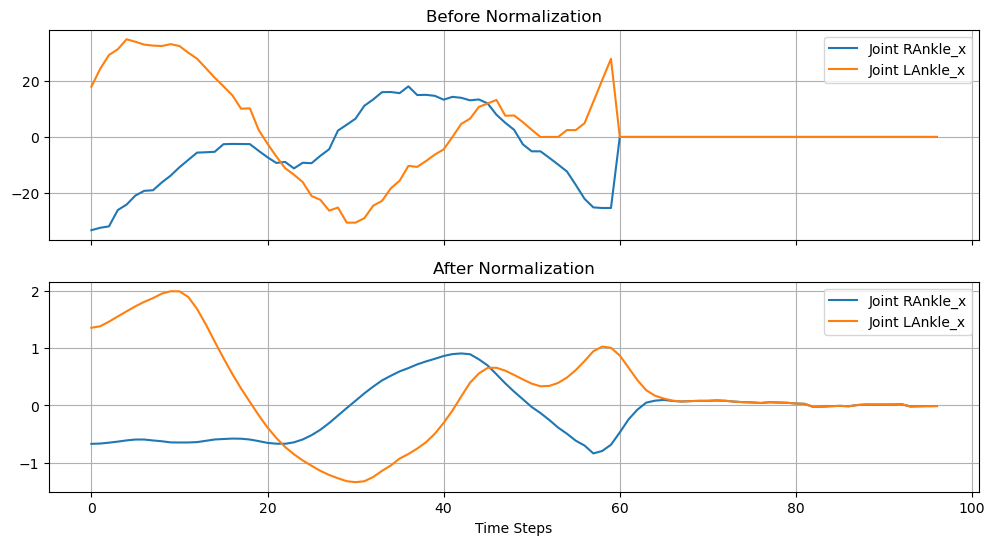

In [5]:
import matplotlib.pyplot as plt

# Choose a sample index
idx = 66

# Get a sample from train_subset (before normalization)
original_sample, _ = train_subset[idx]  # Shape: (num_joints * time_steps,)
original_sample = original_sample.view(len(choosen_joints), -1)  # Reshape to (num_joints, time_steps)

# Get a sample from train_data (after normalization)
normalized_sample, _ = train_data[idx]
normalized_sample = normalized_sample.view(len(choosen_joints), -1)  # Reshape to (num_joints, time_steps)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

for i in range(len(choosen_joints)):
    axes[0].plot(original_sample[i].numpy(), label=f"Joint {choosen_joints[i]}")
    axes[1].plot(normalized_sample[i].numpy(), label=f"Joint {choosen_joints[i]}")

axes[0].set_title("Before Normalization")
axes[1].set_title("After Normalization")

for ax in axes:
    ax.legend()
    ax.grid()
    
plt.xlabel("Time Steps")
plt.show()


In [6]:
class Net(nn.Module):
    def __init__(self, input_channels, hidden1, hidden2, output):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(input_channels, hidden1)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(hidden1, hidden2)
        self.activation2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden2, output)

    def forward(self, input):
        out = self.activation(self.linear1(input))
        out = self.activation2(self.linear2(out))
        out = self.output_layer(out)
        
        return out 

In [7]:
# TODO CHECK IF CORRECT
input_channels = len(dataset[0][0].view(-1)) # get first entry, then item and then first joint
hidden1 = input_channels*2
hidden2 = 64
output = len(set(dataset.labels))
net = Net(input_channels=input_channels, hidden1=hidden1, hidden2=hidden2, output=output)
net

Net(
  (linear1): Linear(in_features=194, out_features=388, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=388, out_features=64, bias=True)
  (activation2): ReLU()
  (output_layer): Linear(in_features=64, out_features=4, bias=True)
)

## Training the Neural Net

In [8]:
seeds = [42, 7, 13, 67, 89]
all_results = []
best_train_cms = []
best_val_cms = []
for seed in seeds:
    net = Net(input_channels=input_channels, hidden1=hidden1, hidden2=hidden2, output=output)
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    results, best_train_cm, best_val_cm = train_and_validate(seed, 
                                                             net, 
                                                             criterion, 
                                                             optimizer, 
                                                             epochs, 
                                                             learning_rate, 
                                                             patience, 
                                                             train_loader, 
                                                             val_loader, 
                                                             device,
                                                             mlp = True
                                                             )
    all_results.append(results)
    best_train_cms.append(best_train_cm)
    best_val_cms.append(best_val_cm)

Training
Epoch: 1/20, Loss: 0.935, Accuracy: 60.311
Validation
Epoch: 1/20, Loss: 0.762, Accuracy: 81.250
Model saved at epoch 1
Training
Epoch: 2/20, Loss: 0.565, Accuracy: 83.658
Validation
Epoch: 2/20, Loss: 0.548, Accuracy: 81.250
Model saved at epoch 2
Training
Epoch: 3/20, Loss: 0.355, Accuracy: 86.381
Validation
Epoch: 3/20, Loss: 0.471, Accuracy: 75.000
Model saved at epoch 3
Training
Epoch: 4/20, Loss: 0.263, Accuracy: 90.272
Validation
Epoch: 4/20, Loss: 0.462, Accuracy: 81.250
Model saved at epoch 4
Training
Epoch: 5/20, Loss: 0.211, Accuracy: 92.607
Validation
Epoch: 5/20, Loss: 0.441, Accuracy: 78.125
Model saved at epoch 5
Training
Epoch: 6/20, Loss: 0.173, Accuracy: 93.385
Validation
Epoch: 6/20, Loss: 0.440, Accuracy: 81.250
Model saved at epoch 6
Training
Epoch: 7/20, Loss: 0.141, Accuracy: 95.720
Validation
Epoch: 7/20, Loss: 0.441, Accuracy: 84.375
Training
Epoch: 8/20, Loss: 0.119, Accuracy: 97.276
Validation
Epoch: 8/20, Loss: 0.426, Accuracy: 84.375
Model saved at

# Plots

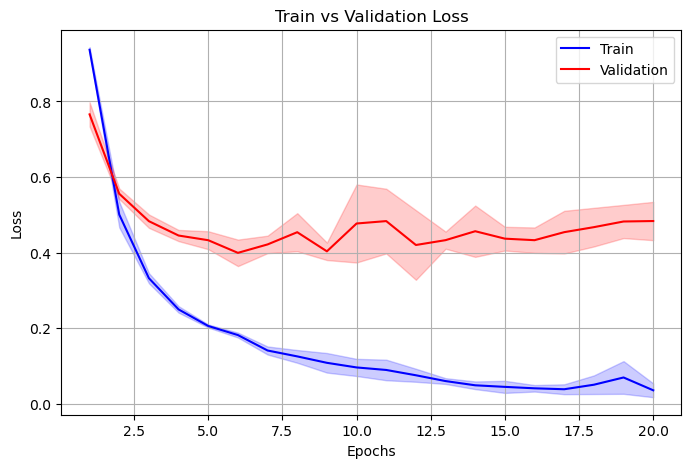

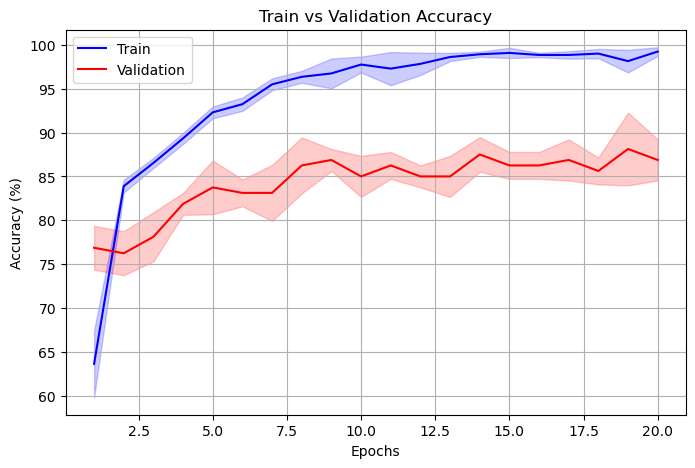

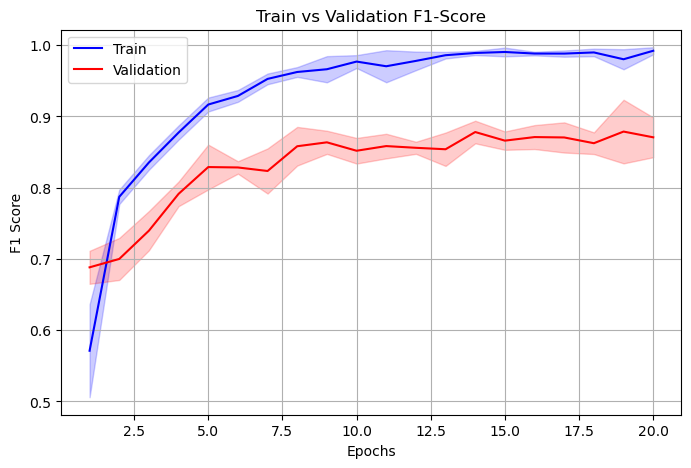

In [9]:
# ChatGPT base code for plots
# Extract metrics
metrics = ["losses", "accs", "precisions", "recalls", "f1s"]
mean_std_results = {metric: {
    "train": compute_mean_std(all_results, f"train_{metric}"),
    "val": compute_mean_std(all_results, f"val_{metric}")
} for metric in metrics}

# Plot combined graphs
plot_train_val(all_results, "losses", "Train vs Validation Loss", "Loss", mean_std_results)
plot_train_val(all_results, "accs", "Train vs Validation Accuracy", "Accuracy (%)", mean_std_results)
plot_train_val(all_results, "f1s", "Train vs Validation F1-Score", "F1 Score", mean_std_results)


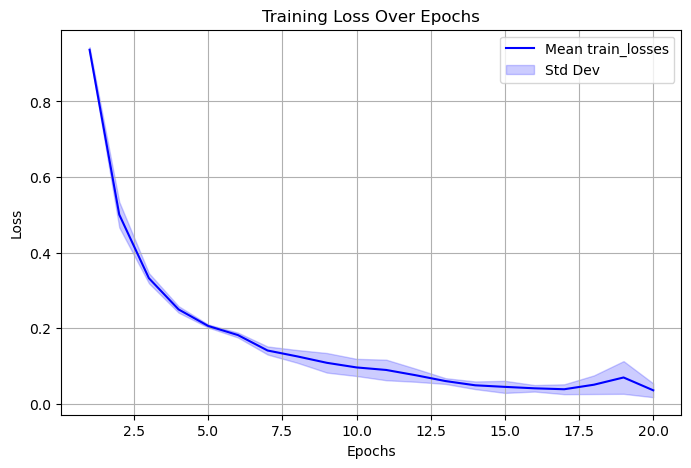

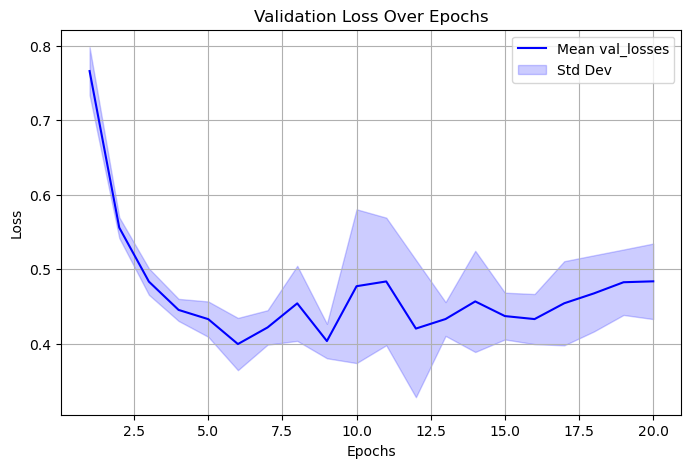

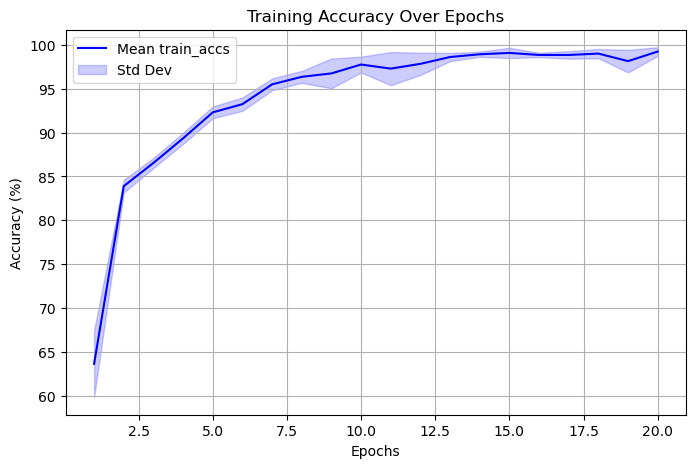

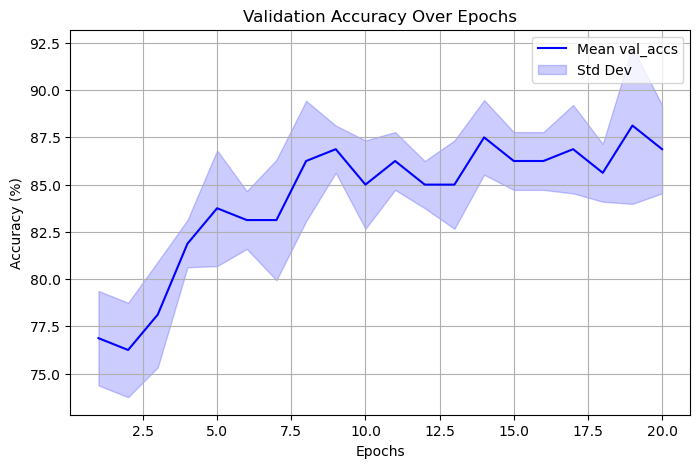

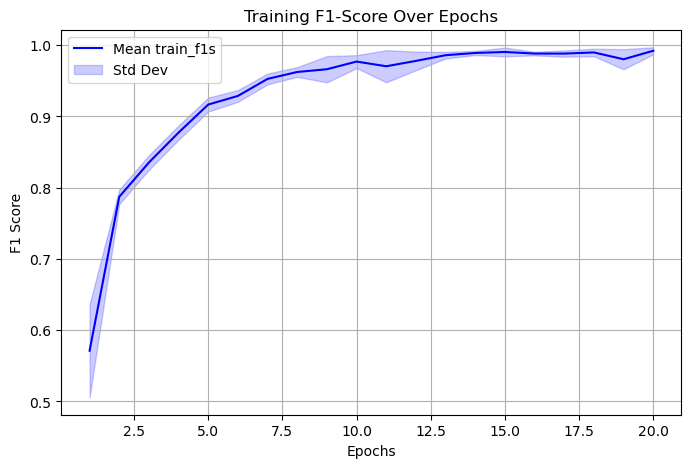

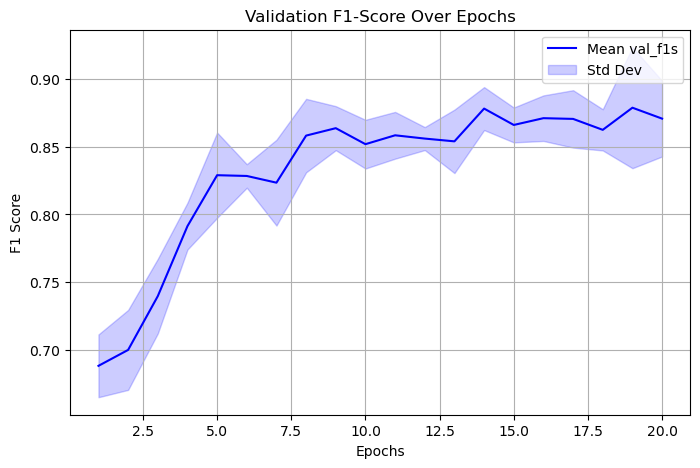

In [10]:
epochs = len(all_results[0]["train_losses"])  # Assuming all have same number of epochs
x = np.arange(1, epochs + 1)  # X-axis values (Epochs)
metrics = ["train_losses", "train_accs", "train_precisions", "train_recalls", "train_f1s",
           "val_losses", "val_accs", "val_precisions", "val_recalls", "val_f1s"]
mean_std_results = {metric: compute_mean_std(all_results, metric) for metric in metrics}

# Plot training loss
plot_metric("train_losses", "Training Loss Over Epochs", x, "Loss", mean_std_results)

# Plot validation loss
plot_metric("val_losses", "Validation Loss Over Epochs", x, "Loss", mean_std_results)

# Plot accuracy
plot_metric("train_accs", "Training Accuracy Over Epochs", x, "Accuracy (%)", mean_std_results)
plot_metric("val_accs", "Validation Accuracy Over Epochs", x, "Accuracy (%)", mean_std_results)

# Plot F1-score
plot_metric("train_f1s", "Training F1-Score Over Epochs", x, "F1 Score", mean_std_results)
plot_metric("val_f1s", "Validation F1-Score Over Epochs", x, "F1 Score", mean_std_results)

____________________________________________________________________________________________________
Results for seed 42


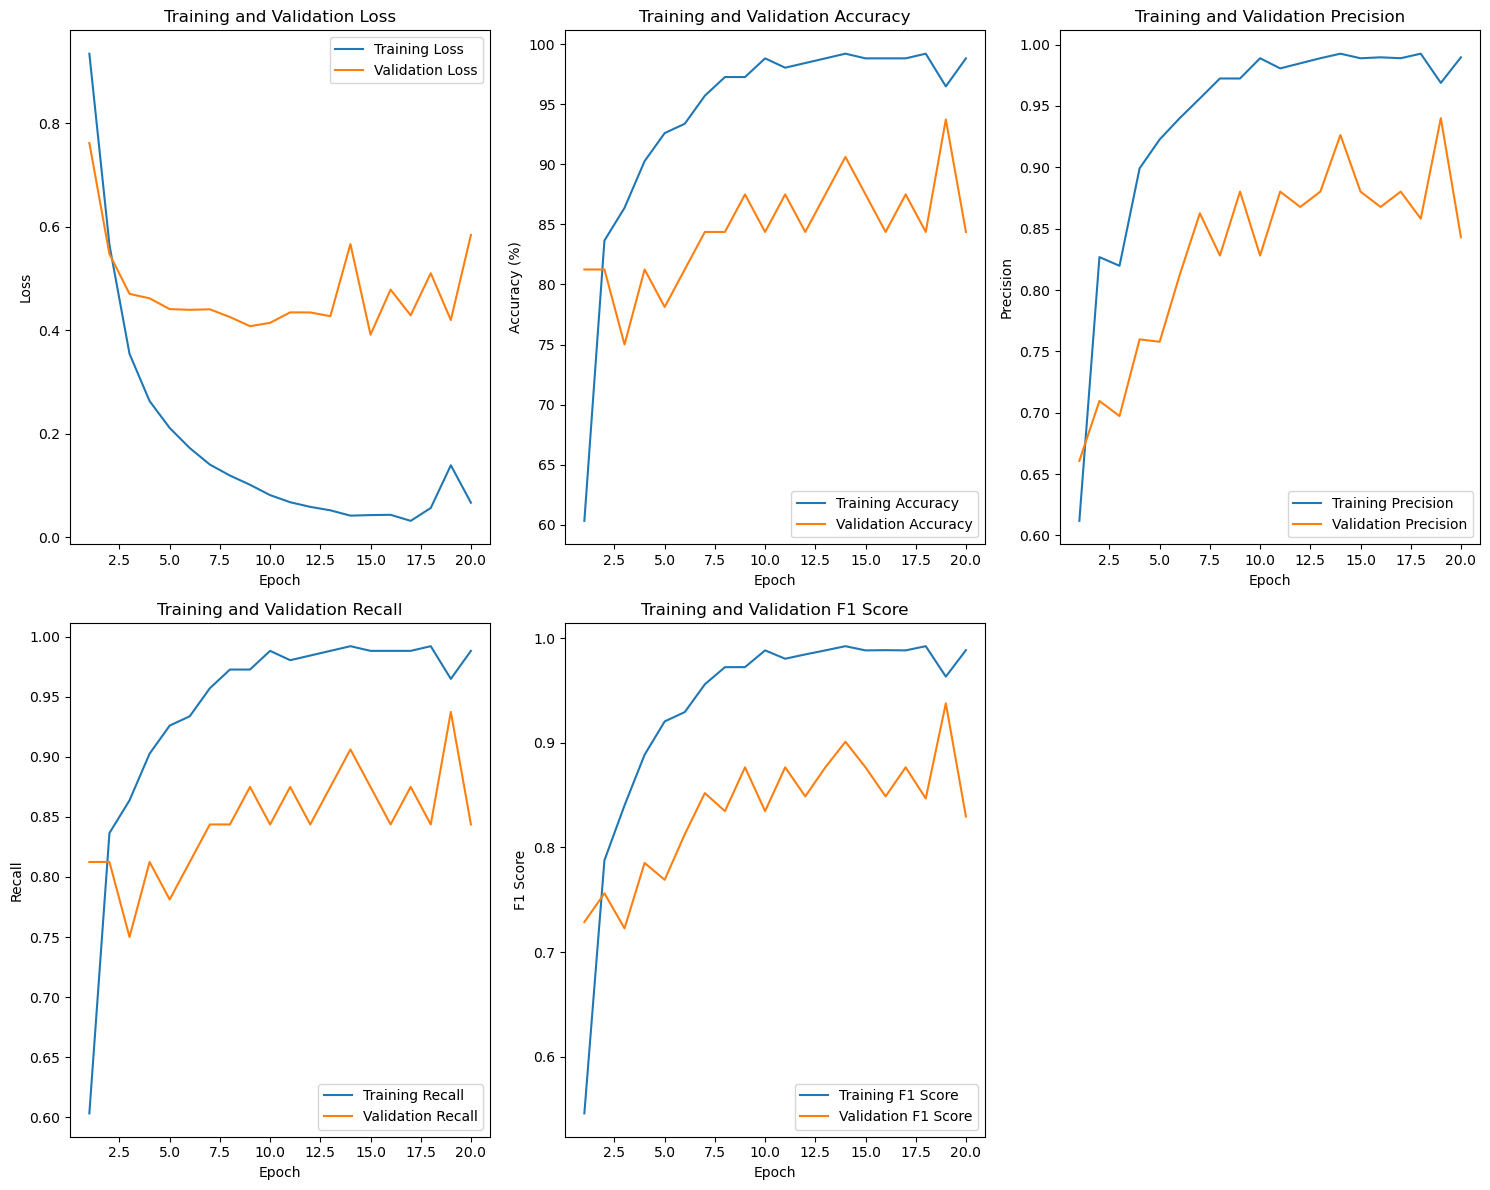

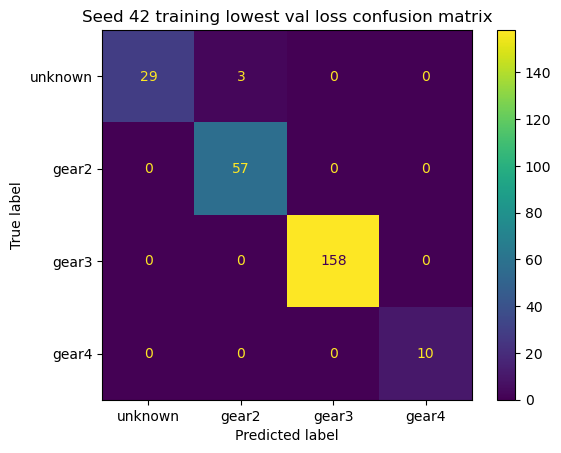

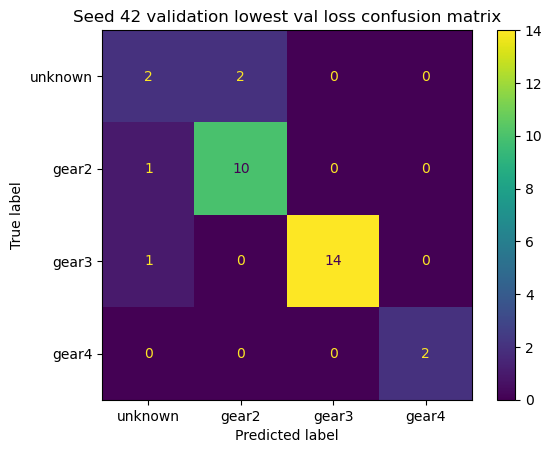

____________________________________________________________________________________________________
Results for seed 7


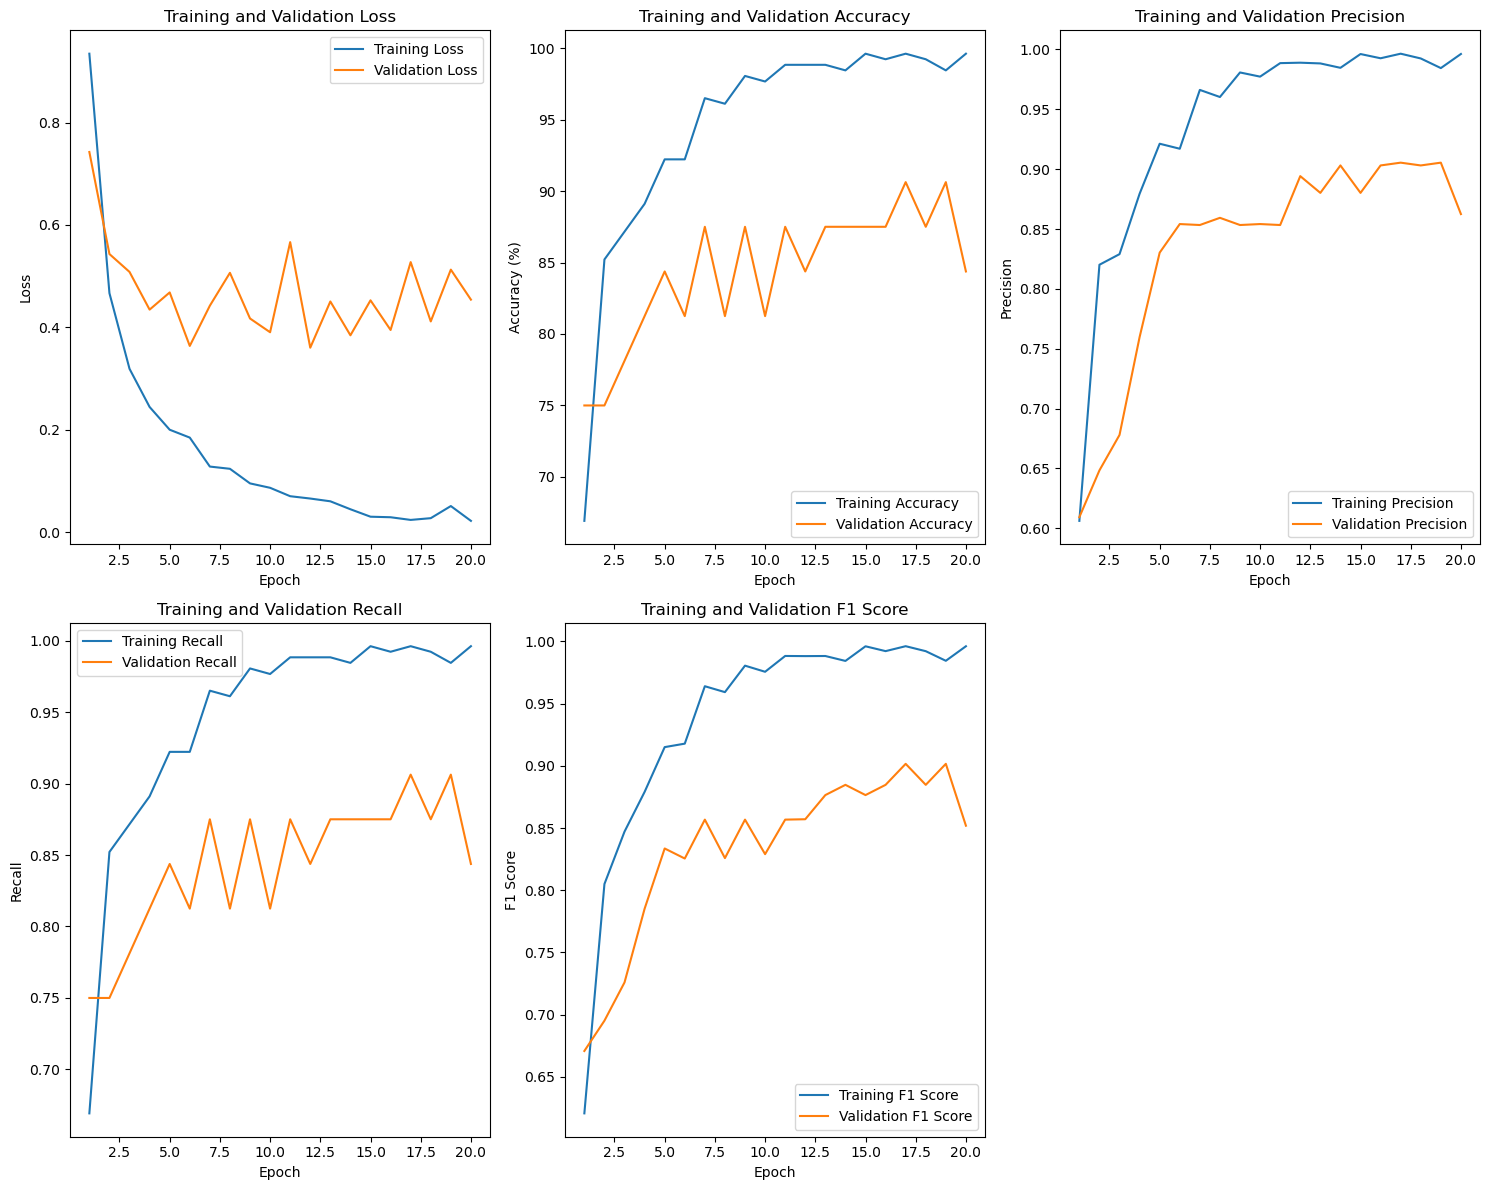

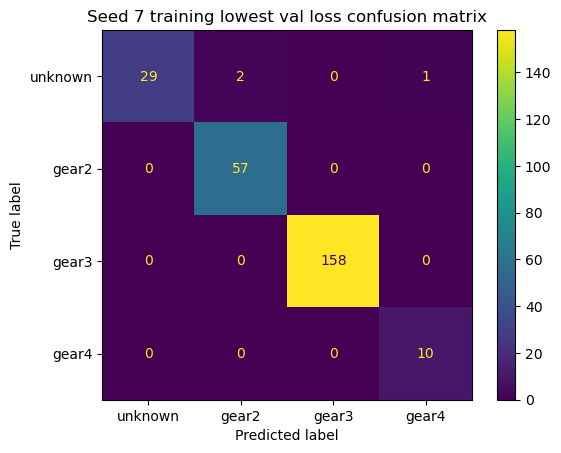

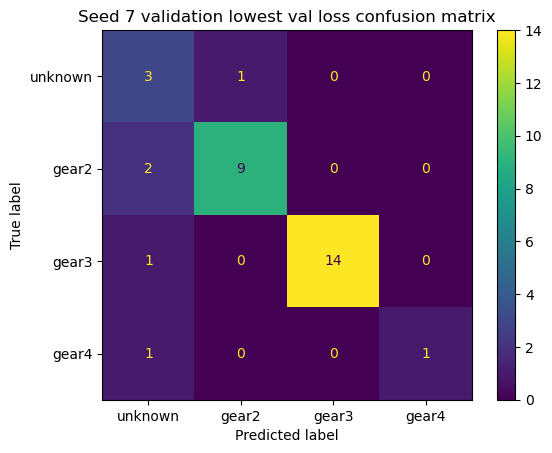

____________________________________________________________________________________________________
Results for seed 13


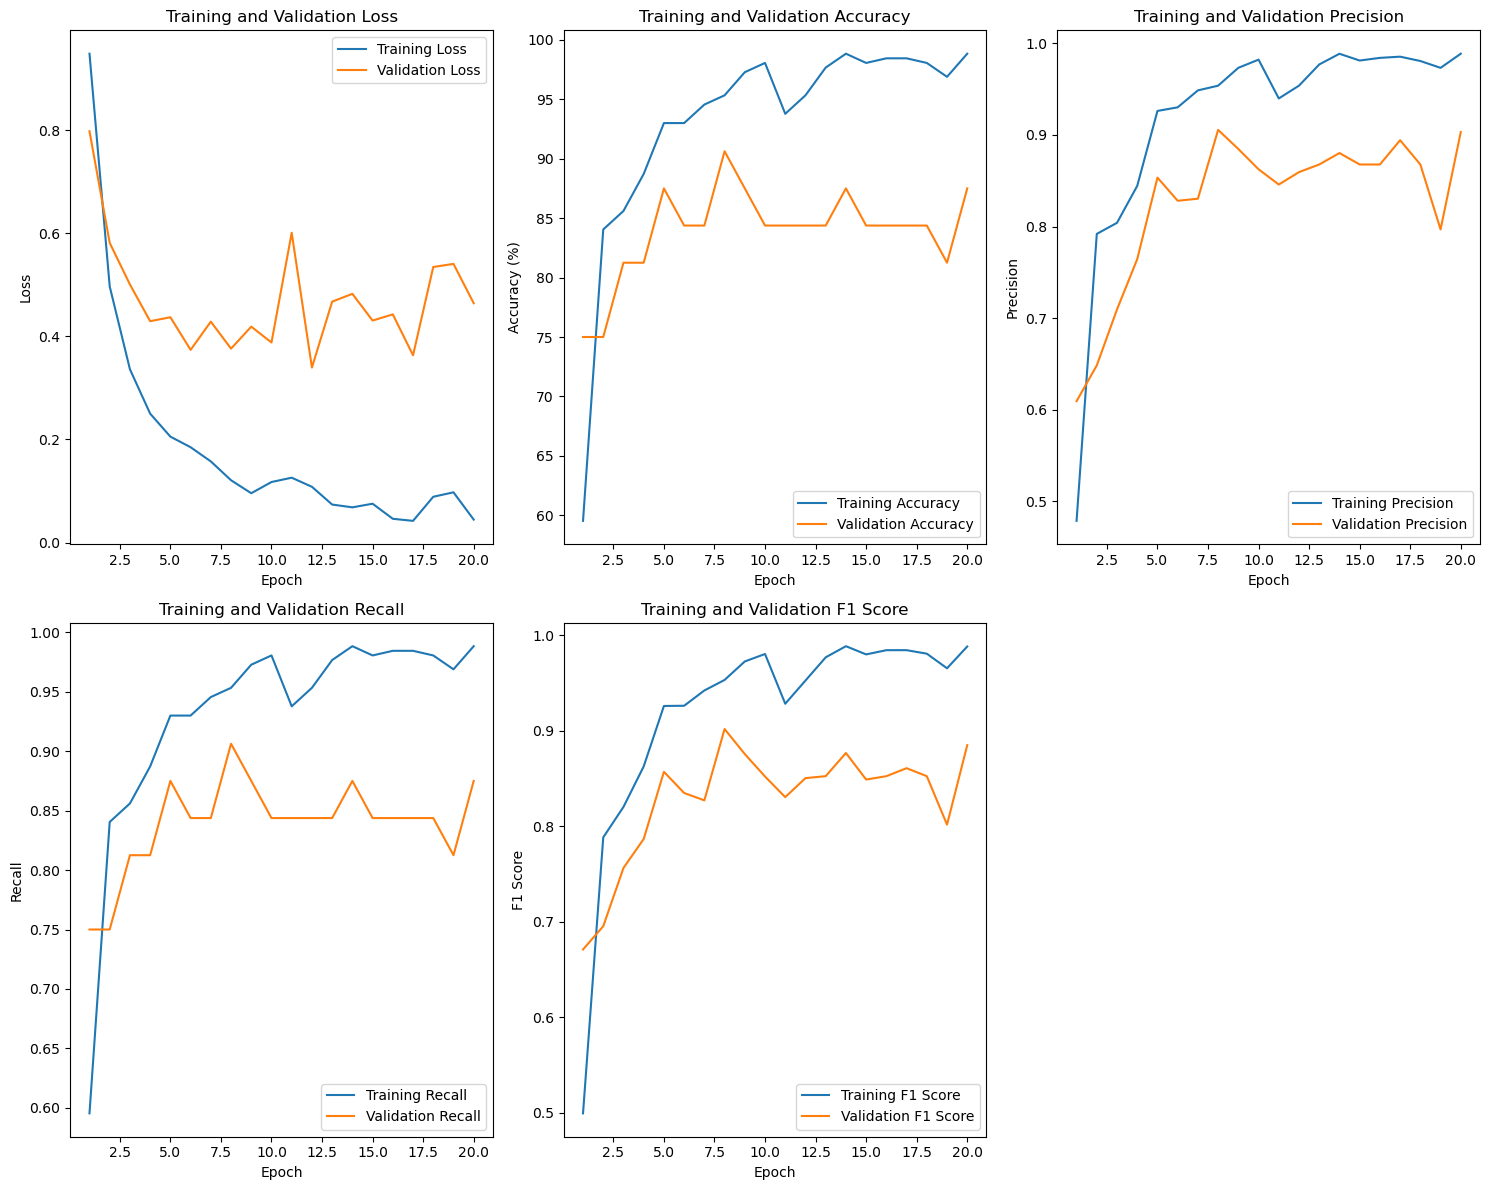

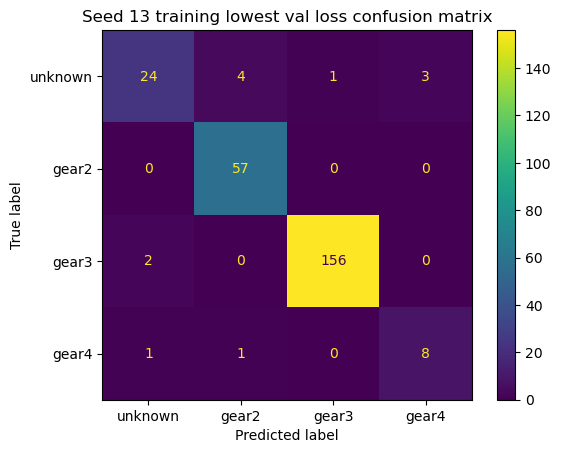

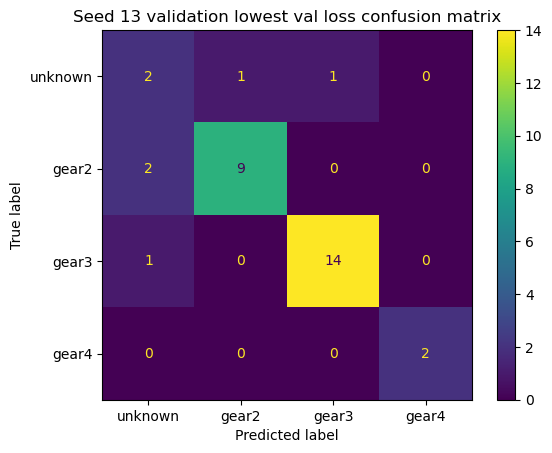

____________________________________________________________________________________________________
Results for seed 67


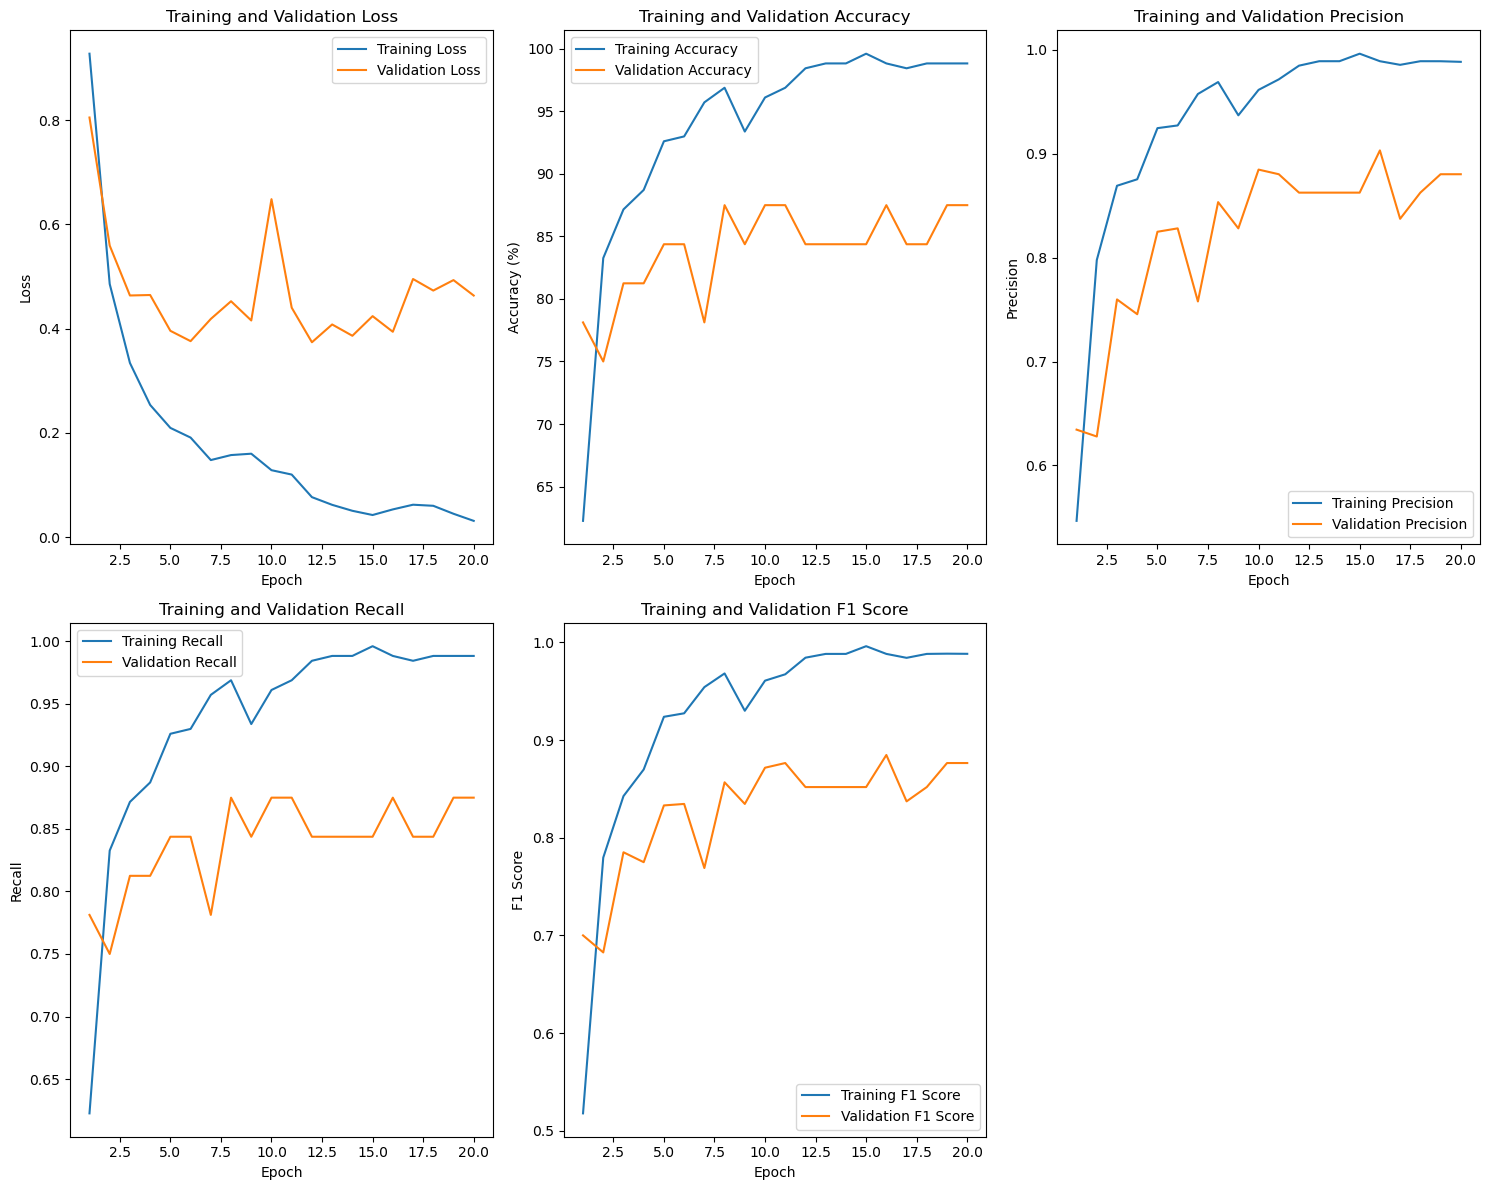

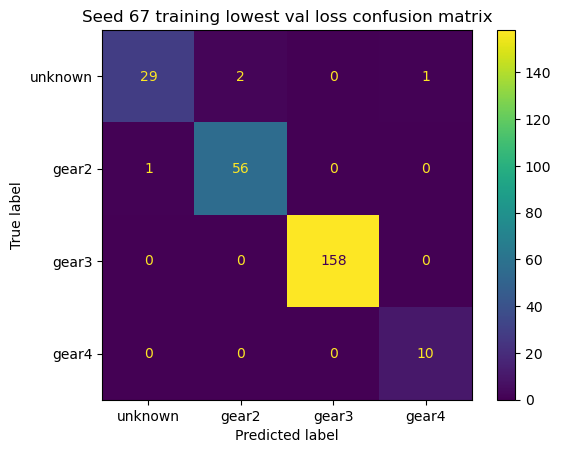

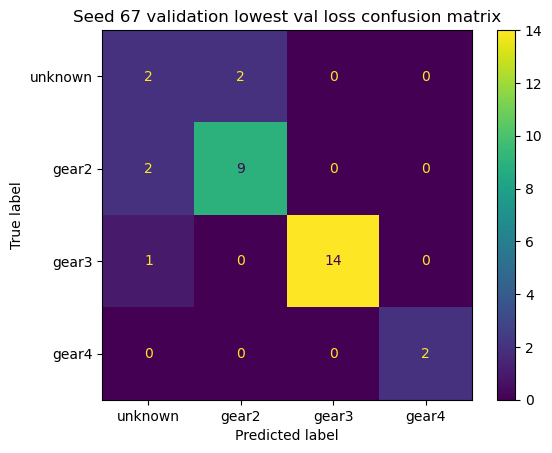

____________________________________________________________________________________________________
Results for seed 89


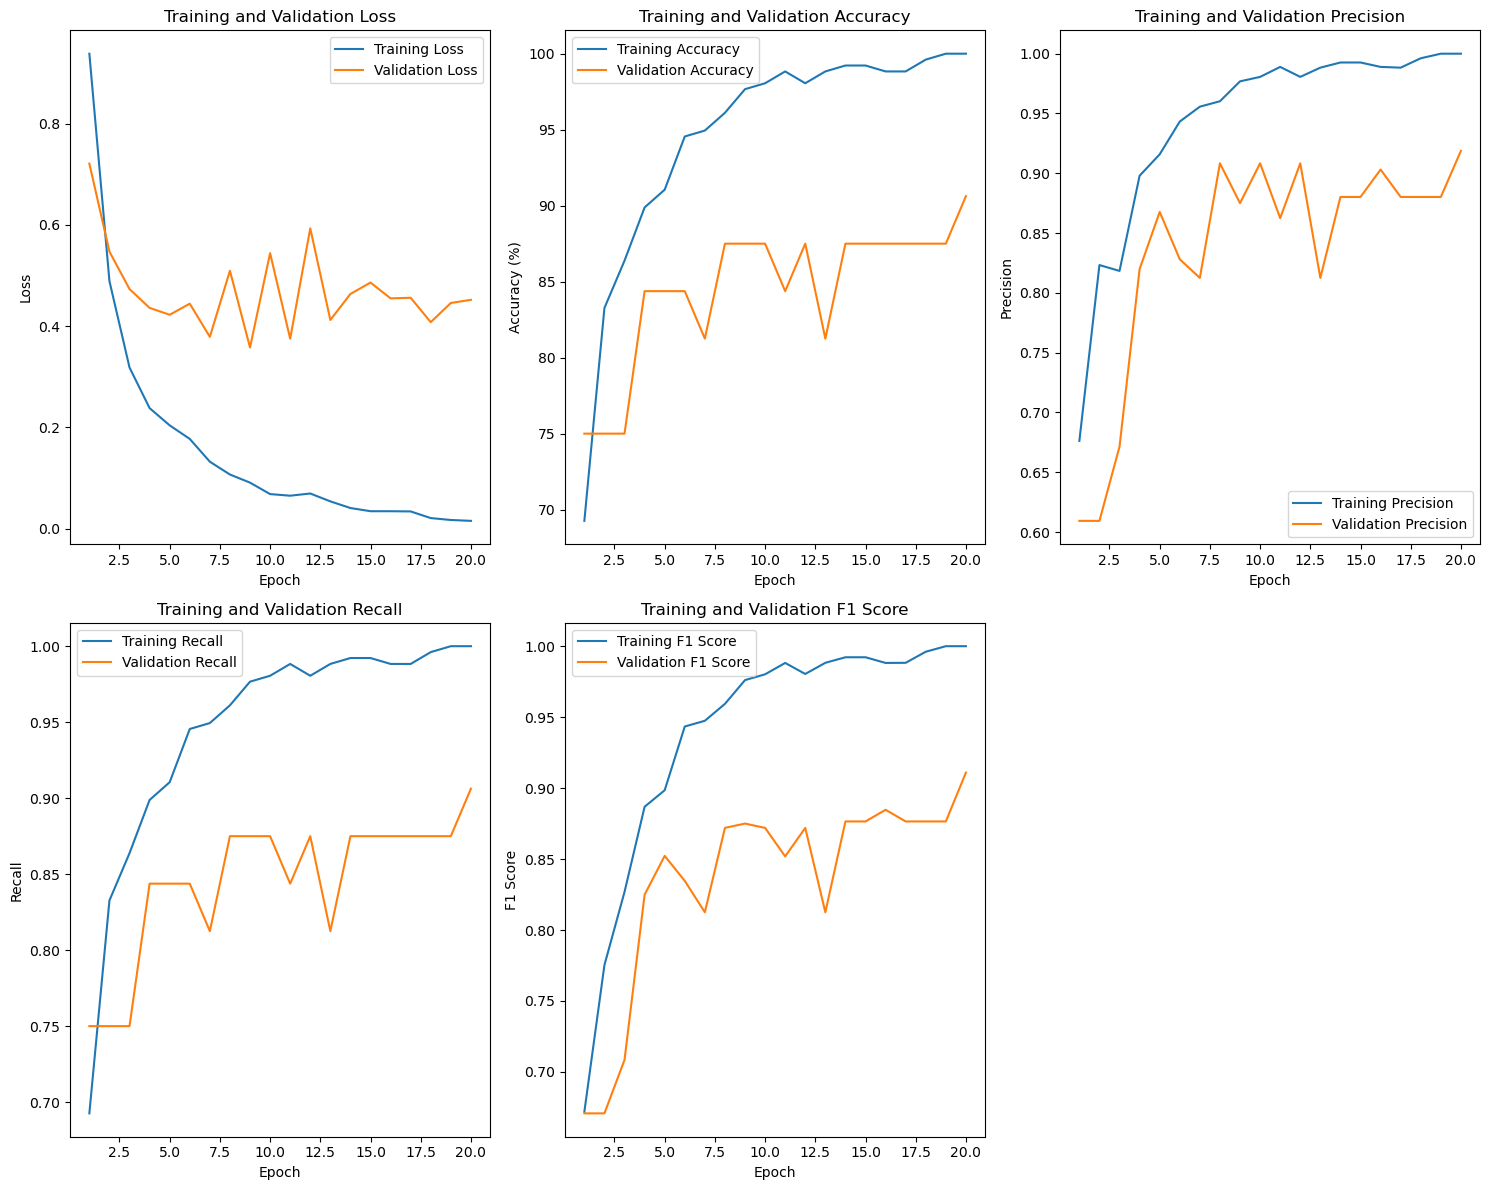

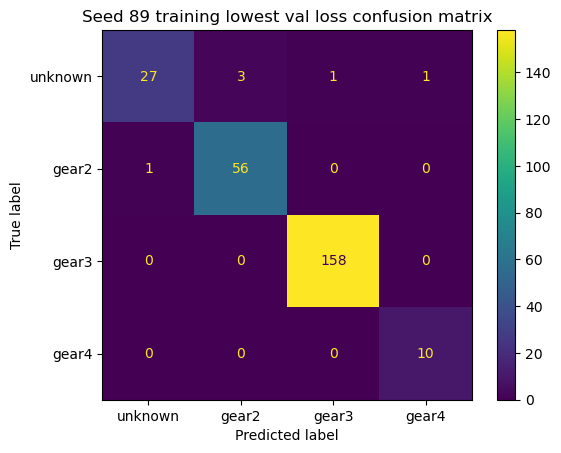

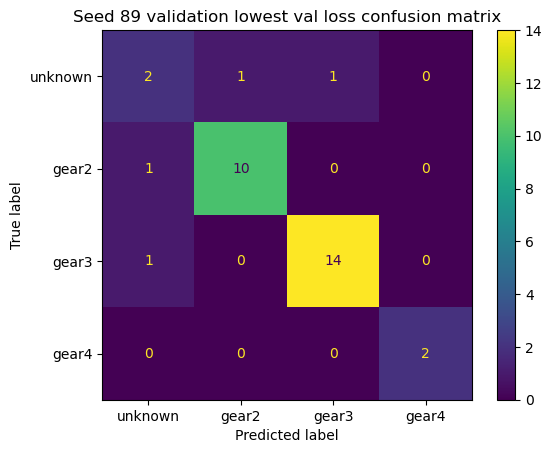

In [11]:
for i, results in enumerate(all_results):    
    epochs_trained = len(results["train_losses"])
    epoch_range = range(1, epochs_trained + 1)

    print("_"*100)
    print(f"Results for seed {seeds[i]}")

    plt.figure(figsize=(15, 12))

    # Plotting training and validation loss
    plt.subplot(2, 3, 1)
    plot_single_metric(epoch_range, results["train_losses"], results["val_losses"], 'Loss', 'Epoch', 'Loss')

    # Plotting training and validation accuracy
    plt.subplot(2, 3, 2)
    plot_single_metric(epoch_range, results["train_accs"], results["val_accs"], 'Accuracy', 'Epoch', 'Accuracy (%)')

    # Plotting training and validation precision
    plt.subplot(2, 3, 3)
    plot_single_metric(epoch_range, results["train_precisions"], results["val_precisions"], 'Precision', 'Epoch', 'Precision')

    # Plotting training and validation recall
    plt.subplot(2, 3, 4)
    plot_single_metric(epoch_range, results["train_recalls"], results["val_recalls"], 'Recall', 'Epoch', 'Recall')

    # Plotting training and validation F1 scores
    plt.subplot(2, 3, 5)
    plot_single_metric(epoch_range, results["train_f1s"], results["val_f1s"], 'F1 Score', 'Epoch', 'F1 Score')

    plt.tight_layout()
    plt.show()

    disp_train_cm = ConfusionMatrixDisplay(best_train_cms[i], display_labels=list(LABELS.keys())[:len(set(dataset.labels))])
    disp_train_cm.plot()
    plt.title(f"Seed {seeds[i]} training lowest val loss confusion matrix")
    plt.show()

    disp_val_cm = ConfusionMatrixDisplay(best_val_cms[i], display_labels=list(LABELS.keys())[:len(set(dataset.labels))])
    disp_val_cm.plot()
    plt.title(f"Seed {seeds[i]} validation lowest val loss confusion matrix")
    plt.show()



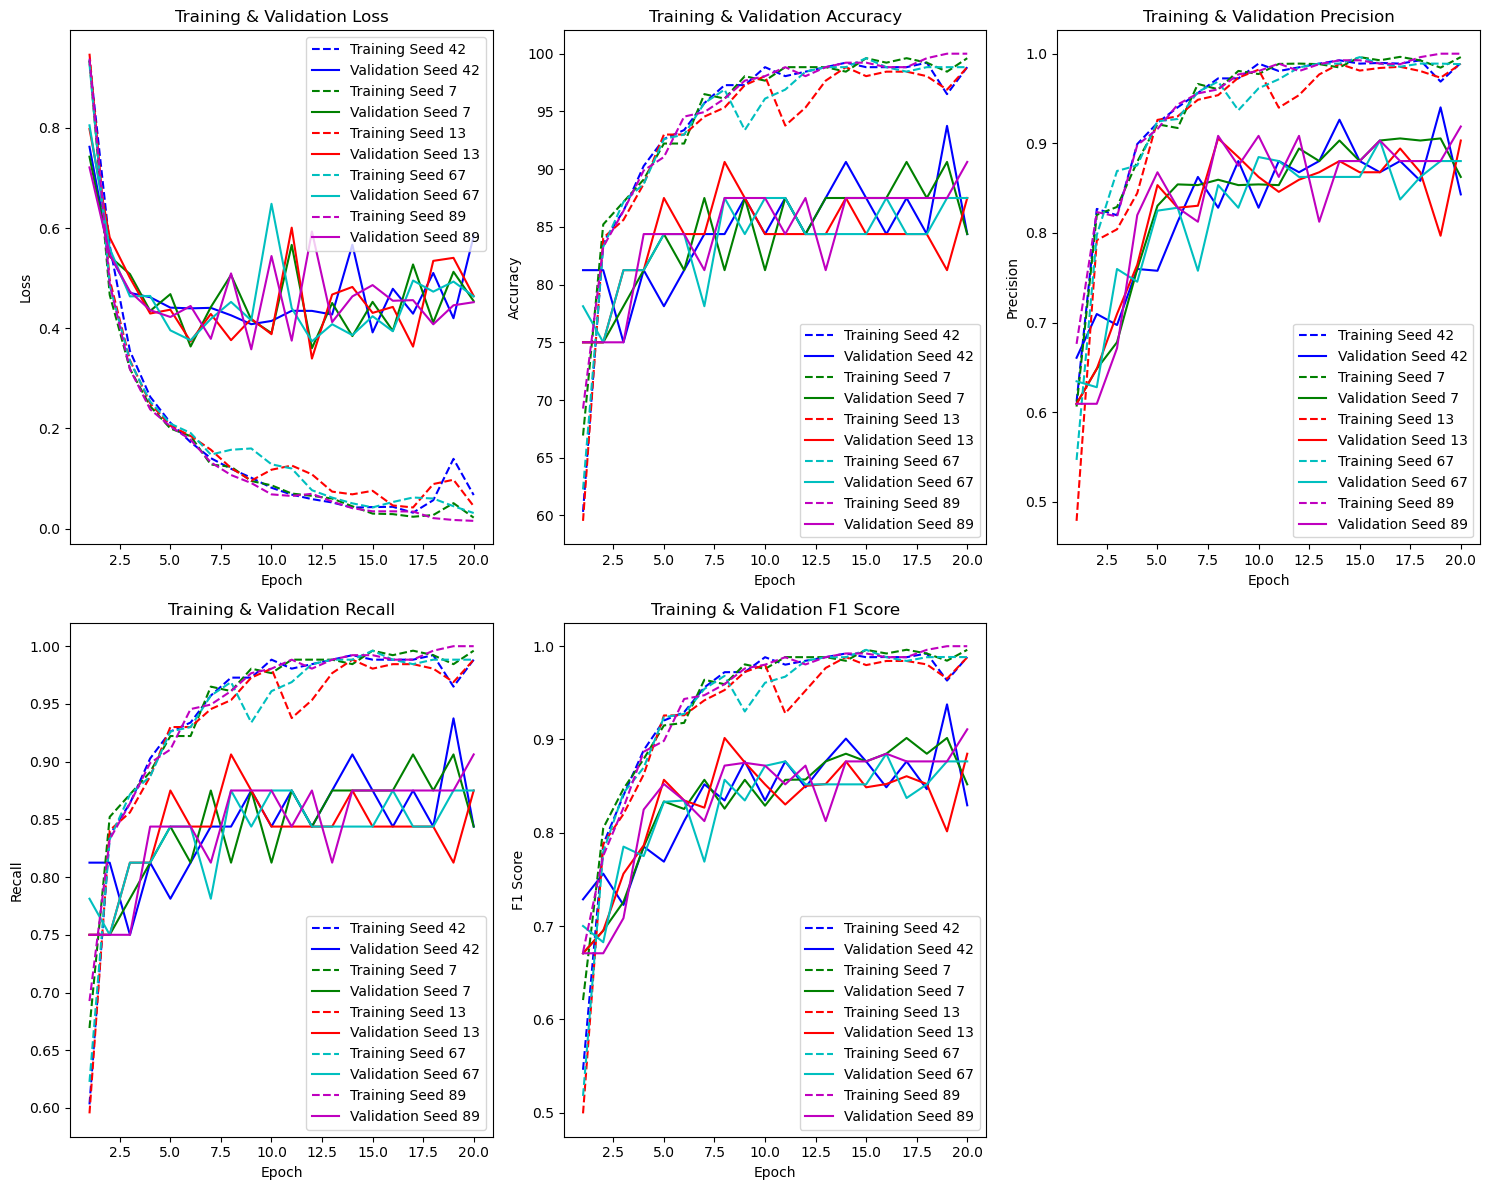

In [12]:
# Define colors for different seeds
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Add more if needed

plt.figure(figsize=(15, 12))

# Metric names and corresponding keys in the results dictionary
metrics = {
    "Loss": ("train_losses", "val_losses"),
    "Accuracy": ("train_accs", "val_accs"),
    "Precision": ("train_precisions", "val_precisions"),
    "Recall": ("train_recalls", "val_recalls"),
    "F1 Score": ("train_f1s", "val_f1s"),
}

# Iterate over each metric and create a subplot for it
for idx, (metric_name, (train_key, val_key)) in enumerate(metrics.items(), 1):
    plt.subplot(2, 3, idx)  # Arrange plots in a 2x3 grid
    
    for i, results in enumerate(all_results):
        epochs_trained = len(results[train_key])
        epoch_range = range(1, epochs_trained + 1)
        color = colors[i % len(colors)]  # Assign a color

        # Plot training metric
        plt.plot(epoch_range, results[train_key], label=f'Training Seed {seeds[i]}', linestyle='--', color=color)
        # Plot validation metric
        plt.plot(epoch_range, results[val_key], label=f'Validation Seed {seeds[i]}', linestyle='-', color=color)

    plt.title(f'Training & Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()

plt.tight_layout()
plt.show()


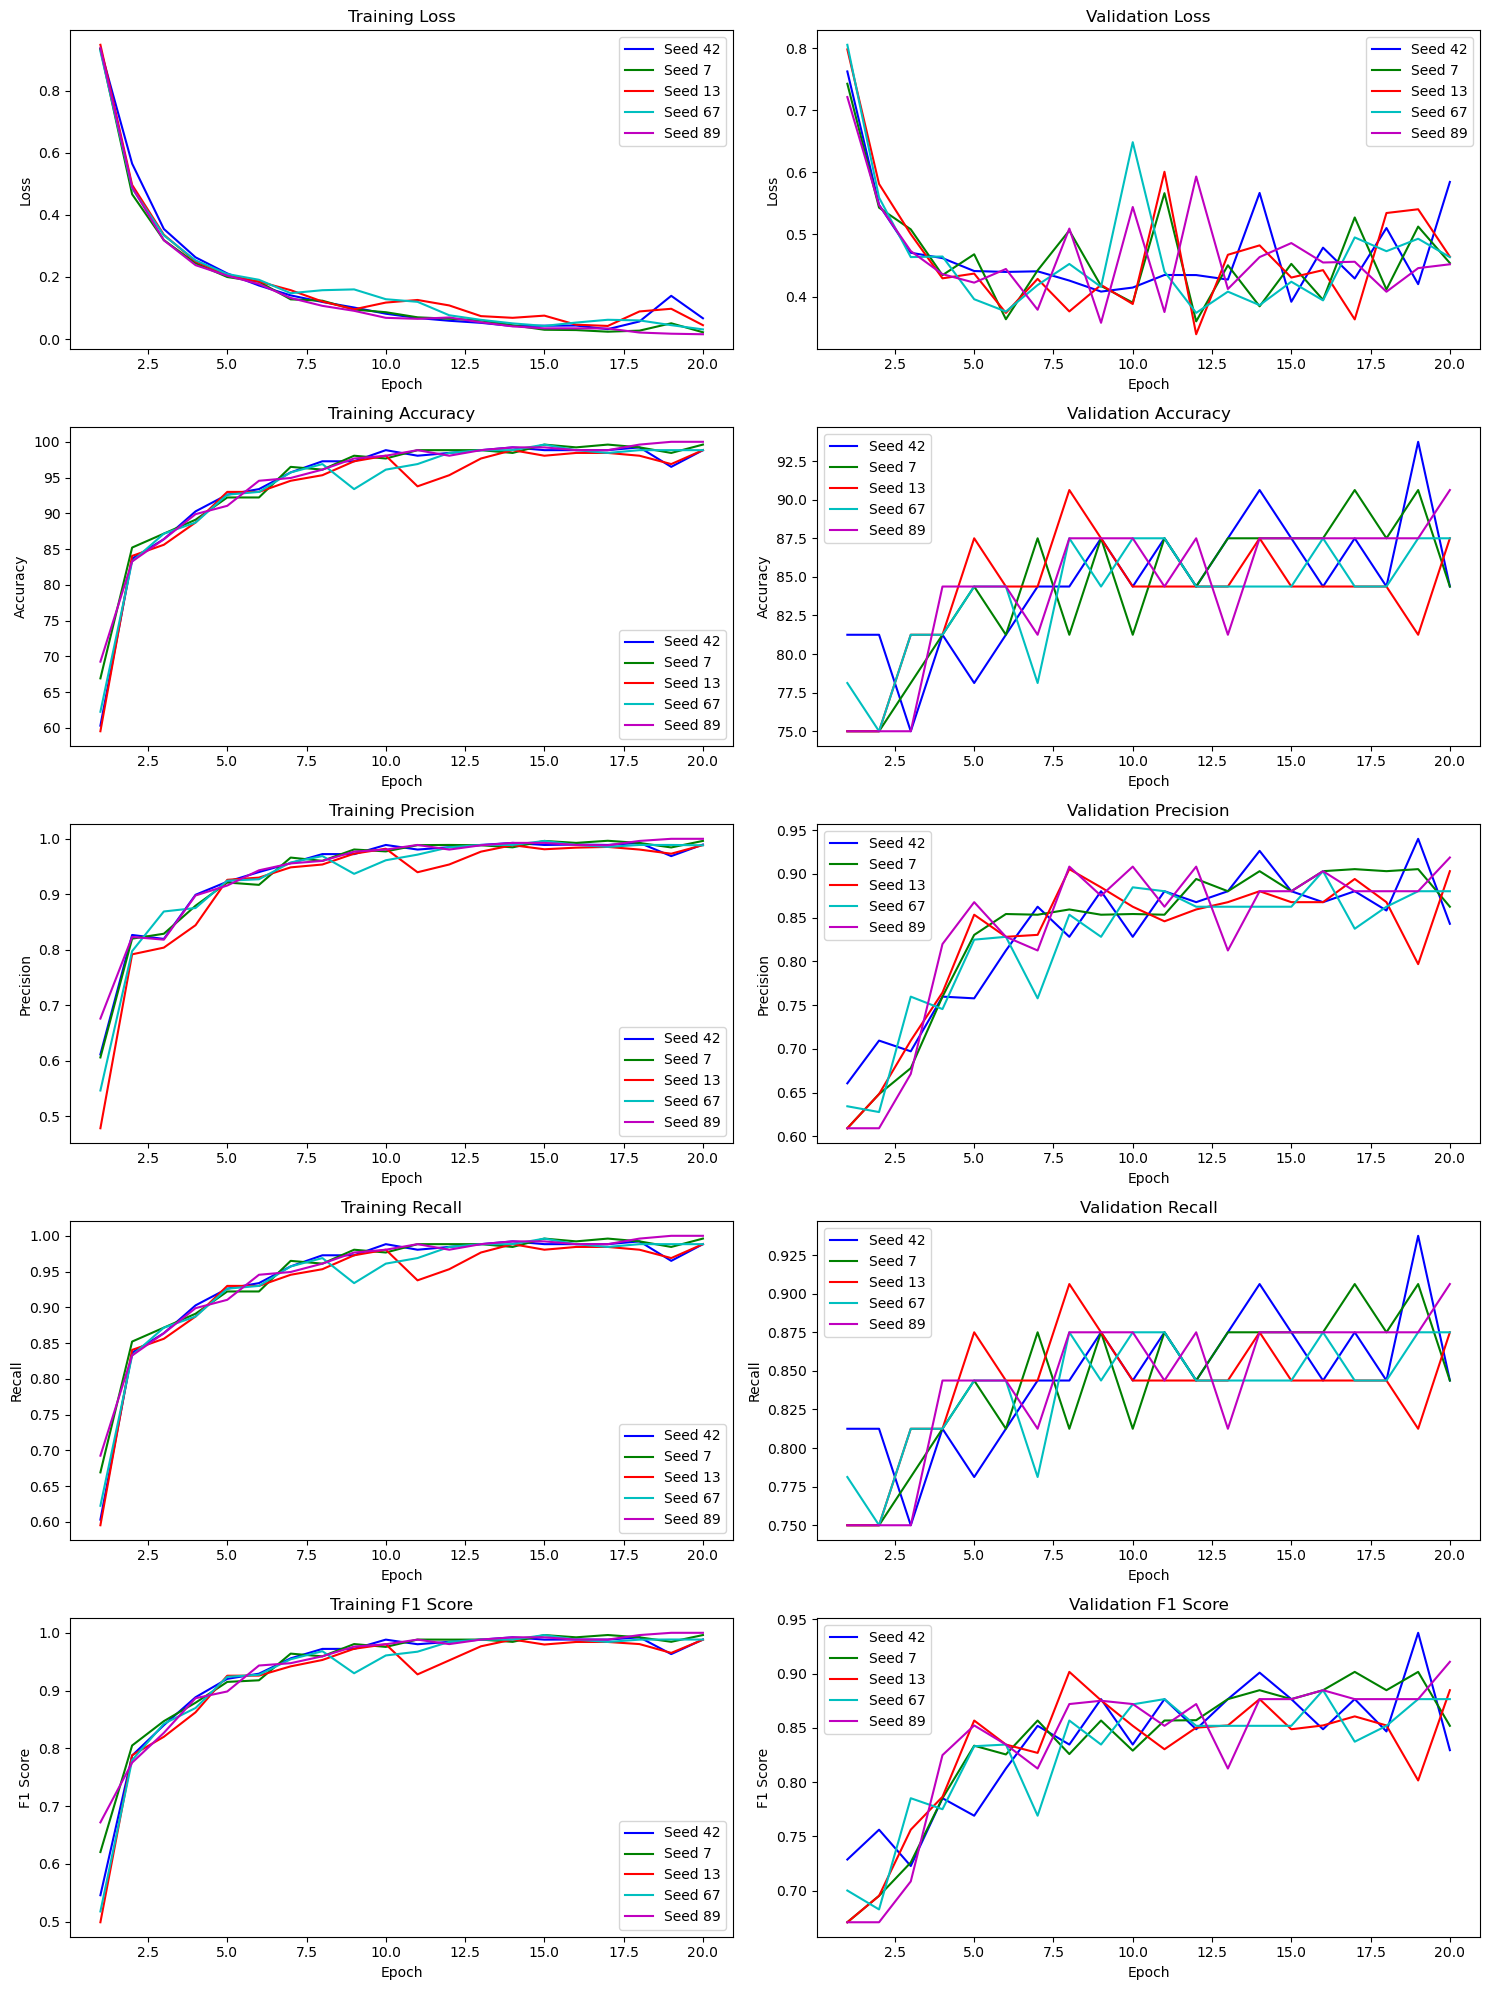

In [13]:
# Define colors for different seeds
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Add more if needed

plt.figure(figsize=(15, 20))  # Larger figure to fit 10 subplots

# Metric names and corresponding keys in the results dictionary
metrics = {
    "Loss": ("train_losses", "val_losses"),
    "Accuracy": ("train_accs", "val_accs"),
    "Precision": ("train_precisions", "val_precisions"),
    "Recall": ("train_recalls", "val_recalls"),
    "F1 Score": ("train_f1s", "val_f1s"),
}

# Iterate over each metric and create subplots
for idx, (metric_name, (train_key, val_key)) in enumerate(metrics.items()):
    
    # Training Plot
    plt.subplot(5, 2, 2 * idx + 1)  # Left column for training
    for i, results in enumerate(all_results):
        epochs_trained = len(results[train_key])
        epoch_range = range(1, epochs_trained + 1)
        color = colors[i % len(colors)]
        
        plt.plot(epoch_range, results[train_key], label=f'Seed {seeds[i]}', color=color)
    
    plt.title(f'Training {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()

    # Validation Plot
    plt.subplot(5, 2, 2 * idx + 2)  # Right column for validation
    for i, results in enumerate(all_results):
        epochs_trained = len(results[val_key])
        epoch_range = range(1, epochs_trained + 1)
        color = colors[i % len(colors)]
        
        plt.plot(epoch_range, results[val_key], label=f'Seed {seeds[i]}', color=color)
    
    plt.title(f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()

plt.tight_layout()
plt.show()
